In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import json

# Create master datasets

* read_csvs

In [30]:
movies_df = pd.read_csv('../movielens_latest/ml-latest-lean/movies.csv')
ratings_df = pd.read_csv('../movielens_latest/ml-latest-lean/ratings.csv', compression='gzip') #
links_df = pd.read_csv('../movielens_latest/ml-latest-lean/links.csv') # 
tmdb_movies_df = pd.read_csv('../tmdb_5000/tmdb_5000_movies.csv') # 
tmdb_credits_df = pd.read_csv('../tmdb_5000/tmdb_5000_credits.csv')
directors_df = pd.read_csv('../../model/director_names.csv', encoding = "ISO-8859-1")

In [31]:
tags_df = pd.read_csv('../movielens_latest/ml-latest-lean/tags.csv')

* merge ratings with tmdb

In [3]:
# df1 = pd.merge(ratings_df, links_df, on='movieId', how='inner')
# assert ratings_df.shape[0]==df1.shape[0]

In [4]:
# df1 = df1.loc[df1['tmdbId'].notnull(), :]
# df1['tmdbId'] = df1['tmdbId'].astype(int)
# df2 = pd.merge(df1, tmdb_movies_df, left_on='tmdbId', right_on='id', how='inner')

In [5]:
# print('Of the total {} ratings we have tmdb information on {} ({:.1f}%).'.format(df1.shape[0], df2.shape[0], 100*df2.shape[0]/df1.shape[0]))
# print('Of the total {} movies we have tmdb information on {} ({:.1f}%).'.format(len(df1['movieId'].unique()), len(df2['movieId'].unique()), 100*len(df2['movieId'].unique())/len(df1['movieId'].unique())))

* merge movies with tmdb

In [6]:
df1 = pd.merge(movies_df, links_df, on='movieId', how='inner')
assert movies_df.shape[0]==df1.shape[0]

In [7]:
df1 = df1.loc[df1['tmdbId'].notnull(), :]
df1['tmdbId'] = df1['tmdbId'].astype(int)
df2 = pd.merge(df1, tmdb_movies_df, left_on='tmdbId', right_on='id', how='inner')

In [8]:
print('Of the total {} movies we have tmdb information on {} ({:.1f}%).'.format(df1.shape[0], df2.shape[0], 100*df2.shape[0]/df1.shape[0]))

Of the total 10708 movies we have tmdb information on 3868 (36.1%).


* merge in credits (cast etc)

In [9]:
df3 = pd.merge(df2, tmdb_credits_df, left_on='tmdbId', right_on='movie_id', how='inner')
assert df2.shape[0]==df3.shape[0]

* parsing

In [10]:
df4 = df3.copy()

In [11]:
def genre_parser(genre_str):
    kws = []
    for i in json.loads(genre_str):
        kws.extend(i['name'].lower().split(' '))
    kws = list(set(kws))
    return kws

In [12]:
df4['genre_kws'] = df4['genres_y'].apply(genre_parser)

In [13]:
def keyword_parser(kw_str):
    kws = []
    for i in json.loads(kw_str):
        if i['name'] in ['duringcreditsstinger', 'aftercreditsstinger']:
            i['name'] = 'epilogue'
        kws.extend(i['name'].lower().split(' '))
    kws = list(set(kws))
    return kws

In [14]:
df4['description_kws'] = df4['keywords'].apply(keyword_parser)

In [15]:
def cast_parser(cast_str):
    kws = []
    top_bill = 0
    for i in json.loads(cast_str):
        top_bill = top_bill+1
        if top_bill<=3:
            kws.extend(i['name'].split(' '))
    kws = list(set(kws))
    return kws

In [16]:
df4['cast_kws'] = df4['cast'].apply(cast_parser)

In [17]:
df4['qmdbId'] = df4['movieId'].index

In [18]:
df4['year'] = df4['release_date'].apply(lambda x: x[:4]).astype(int)

In [20]:
# add director
df5 = pd.merge(df4, directors_df, on='movie_id', how='left')
df5.loc[df5['title']=='Dream with the Fishes', 'director_name'] = 'Finn Taylor'
assert np.sum(df5['director_name'].isnull())==0

df5['director_name'] = df5['director_name'].apply(lambda x: x.split(' '))

actor_director = []
for cast, director in df5[['cast_kws','director_name']].values:
    cast = list(cast)
    director = list(director)
    actor_director.append(cast+director)

df5['cast_kws'] = actor_director

In [33]:
df6 = df5[['qmdbId','movieId','tmdbId','imdbId','year','genre_kws','description_kws','cast_kws']]

In [34]:
df6.head(3)

,qmdbId,movieId,tmdbId,imdbId,year,genre_kws,description_kws,cast_kws
0,0,0,862,114709,1995,"[comedy, family, animation]","[comes, friends, next, jealousy, rivalry, life...","[Rickles, Tom, Allen, Hanks, Tim, Don, John, L..."
1,1,9,710,113189,1995,"[action, adventure, thriller]","[pulse, base, special, ejection, cuba, accused...","[Brosnan, Pierce, Izabella, Sean, Scorupco, Be..."
2,2,10,9087,112346,1995,"[comedy, drama, romance]","[usa, widower, house, white, wildlife, new, co...","[Douglas, Fox, Bening, Annette, Michael, J., R..."


# Outputs

In [35]:
movies_with_kws_df = pd.merge(movies_df, df6, on='movieId', how='inner')
assert movies_with_kws_df.shape[0]==df6.shape[0]
ratings_with_kws_df = pd.merge(ratings_df, df6, on='movieId', how='inner')

In [36]:
movies_with_kws_df.to_csv('../processed_data/movies_with_kws.csv', index=False)
ratings_with_kws_df.to_csv('../processed_data/ratings_with_kws.csv', compression='gzip', index=False)
df6.to_csv('../processed_data/keyword_lookup.csv', index=False)

# Summary statistics

* count occurence of each keyword

In [23]:
df3.columns

Index(['movieId', 'title_x', 'genres_x', 'imdbId', 'tmdbId', 'budget',
       'genres_y', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title_y', 'vote_average',
       'vote_count', 'movie_id', 'title', 'cast', 'crew'],
      dtype='object')

* genres_y, keywords, spoken_languages, production_countries, subset_crew, check_cast_id=actor_id

In [31]:
def kw_ctr(df, column, id_name):
    cnt = Counter()
    for row in df[column]:
        row = json.loads(row)
        for keyword in row:
            cnt[keyword[id_name]] += 1
    print('{} has {} unique keywords.'.format(column, len(cnt)))
    return cnt

In [32]:
# def kw_ctr(df, column, id_name):
#     cnt = Counter()
#     for row in df[column]:
#         row = json.loads(row)
#         top_bill = 0
#         for keyword in row:
#             top_bill = top_bill+1
#             if top_bill<=3:
#                 cnt[keyword[id_name]] += 1
#     print('{} has {} unique keywords.'.format(column, len(cnt)))
#     return cnt

* genre keywords

genres_y has 20 unique keywords.


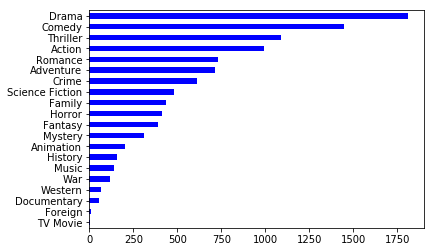

In [33]:
genre_ct = pd.Series(kw_ctr(df3, 'genres_y', 'name')) # 'id'
genre_ct.sort_values().plot(kind='barh', color='blue')

* description keywords

In [34]:
keywords_ct = pd.Series(kw_ctr(df3, 'keywords', 'id'))

keywords has 9393 unique keywords.


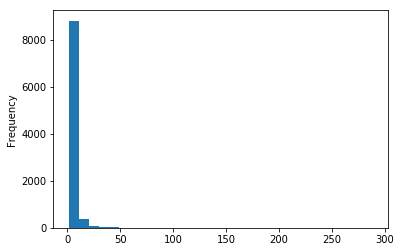

In [35]:
keywords_ct.plot(kind='hist', bins=30)

In [36]:
print('keywords that appear for 5 or more movies {}/{} ({:.1f}%)'.format(
    np.sum(keywords_ct>=5),
    len(keywords_ct),
    100*np.sum(keywords_ct>=5)/len(keywords_ct),
)) 

keywords that appear for 5 or more movies 1602/9393 (17.1%)


* 10 most common words

In [39]:
keywords_ct = pd.Series(kw_ctr(df3, 'keywords', 'name'))
keywords_ct.sort_values(ascending=False)[:50]

keywords has 9393 unique keywords.


duringcreditsstinger       289
independent film           241
woman director             233
based on novel             185
murder                     168
aftercreditsstinger        161
violence                   140
dystopia                   137
revenge                    108
sport                      102
friendship                  97
sex                         96
musical                     92
sequel                      91
biography                   91
teenager                    90
3d                          88
new york                    86
love                        83
police                      79
los angeles                 78
suspense                    77
alien                       74
high school                 71
superhero                   67
drug                        67
prison                      66
dying and death             66
london england              65
nudity                      64
family                      63
father son relationship     63
daughter

In [30]:
print('words that appear in 5 or more movie descriptions {}/{} ({:.1f}%)'.format(
    np.sum(keywords_ct>=5),
    len(keywords_ct),
    100*np.sum(keywords_ct>=5)/len(keywords_ct),
)) 

words that appear in 5 or more movie descriptions 1602/9393 (17.1%)


* actor keywords

In [31]:
actor_ct = pd.Series(kw_ctr(df3, 'cast', 'id'))

cast has 49283 unique keywords.


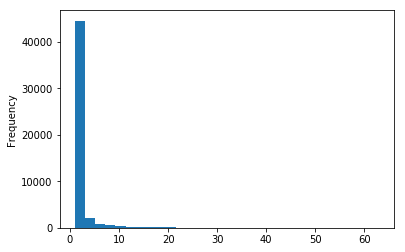

In [32]:
actor_ct.plot(kind='hist', bins=30)

* 10 most prolific actors

In [33]:
actor_ct = pd.Series(kw_ctr(df3, 'cast', 'name'))
actor_ct.sort_values(ascending=False)[:20]

cast has 48950 unique keywords.


Samuel L. Jackson     63
Robert De Niro        54
Matt Damon            49
Bruce Willis          49
Morgan Freeman        45
Johnny Depp           40
Steve Buscemi         40
Liam Neeson           39
Owen Wilson           38
John Goodman          38
Alec Baldwin          38
Stanley Tucci         38
Brad Pitt             37
Nicolas Cage          37
Willem Dafoe          36
Paul Giamatti         36
Jim Broadbent         36
Will Ferrell          35
Christopher Walken    35
J.K. Simmons          35
dtype: int64

In [34]:
print('actors that appear in 5 or more movies {}/{} ({:.1f}%)'.format(
    np.sum(actor_ct>=5),
    len(actor_ct),
    100*np.sum(actor_ct>=5)/len(actor_ct),
)) 

actors that appear in 5 or more movies 3382/48950 (6.9%)


* get director

In [35]:
# def kw_ctr_director(df, column, id_name):
#     cnt = Counter()
#     for row in df[column]:
#         row = json.loads(row)
#         director_entry = [credit for credit in row if credit['job']=='Director'][0]
#         print(director_entry)
#         cnt[director_entry[id_name]] += 1
#     print('{} has {} unique keywords.'.format(column, len(cnt)))
#     return cnt